In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset, singleCET_ProjectedDataset
from cryoS2Sdrop.model import Denoising_3DUNet, Denoising_3DUNet_v2
from cryoS2Sdrop.losses import self2self_L2Loss
from cryoS2Sdrop.trainer import denoisingTrainer
from cryoS2Sdrop.predict import load_model, predict_full_tomogram, get_predictions
from cryoS2Sdrop.analyze import plot_centralSlices, scale, standardize

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
import json

from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio
from torchsummary import summary
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

PARENT_PATH = setup.PARENT_PATH

def parse_null_arg(arg, dtype):
    try:
        return dtype(arg)
    except ValueError:
        return None
    
def get_metrics(X, Y):
    X = scale(X).unsqueeze(0).unsqueeze(0)
    Y = scale(Y).unsqueeze(0).unsqueeze(0)
    
    _ssim = float(ssim(X, Y, data_range=1))
    _psnr = float(peak_signal_noise_ratio(X, Y, data_range=1))

    return _ssim, _psnr

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Model 8

In [2]:
version = 'version_3'
logdir = 'data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/fourierBernoulli_dropoutLevel_comparison/'
logdir = os.path.join(PARENT_PATH, logdir+'%s/' %version)

with open(os.path.join(logdir, "experiment_args.json"), "r") as f:
    exp_args = json.load(f)

deconv_kwargs = exp_args["deconv_kwargs"]
predict_simRecon = exp_args["predict_simRecon"]
use_deconv_as_target = exp_args["use_deconv_as_target"]
weightedBernoulliMask_prob = parse_null_arg(
    exp_args["weightedBernoulliMask_prob"], float
)

model, hparams = load_model(logdir, DataParallel=True)

dataset = hparams['dataset']

cet_path = hparams['tomo_path']
gt_cet_path = hparams['gt_tomo_path']
p = float(hparams['p']) # dropout (zeroing) probability
subtomo_length = int(hparams['subtomo_length'])
n_features = int(hparams['n_features'])
volumetric_scale_factor = float(hparams['vol_scale_factor'])
Vmask_probability = float(hparams['Vmask_probability'])
Vmask_pct = float(hparams['Vmask_pct'])
alpha = hparams['loss_fn']['alpha']

n_bernoulli_samples = 1

In [4]:
if dataset == "singleCET_dataset":
    my_dataset = singleCET_dataset(
        cet_path,
        subtomo_length=subtomo_length,
        p=p,
        n_bernoulli_samples=n_bernoulli_samples,
        volumetric_scale_factor=volumetric_scale_factor,
        Vmask_probability=Vmask_probability,
        Vmask_pct=Vmask_pct,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        **deconv_kwargs
    )

elif dataset == "singleCET_FourierDataset":
    my_dataset = singleCET_FourierDataset(
        cet_path,
        subtomo_length=subtomo_length,
        p=p,
        n_bernoulli_samples=n_bernoulli_samples,
        total_samples=150,
        volumetric_scale_factor=volumetric_scale_factor,
        Vmask_probability=Vmask_probability,
        Vmask_pct=Vmask_pct,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        **deconv_kwargs
    )

elif dataset == "singleCET_ProjectedDataset":
    my_dataset = singleCET_ProjectedDataset(
        cet_path,
        subtomo_length=subtomo_length,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        predict_simRecon=predict_simRecon,
        use_deconv_as_target=use_deconv_as_target,
        **deconv_kwargs
    )

Creating Fourier samples...
Done!


In [6]:
# plt.figure(figsize=(12, 8))
# plt.imshow(my_dataset.simRecon0[my_dataset.tomo_shape[0]//2])

## Full tomogram prediction

In [7]:
torch.cuda.empty_cache()

### resampling vs no resampling

#### Bernoulli Case

In [22]:
# real Bernoulli case
ssim_list0 = []
psnr_list0 = []

ssim_list1 = []
psnr_list1 = []

my_range = [0, 10, 30, 50, 80, 120, 160, 200, 300]

for i in my_range:
    print(i)
    denoised_tomo = predict_full_tomogram(my_dataset, model, resample_patch_each_iter=True, N=i)
    X = torch.tensor(denoised_tomo).unsqueeze(0).unsqueeze(0)
    X = my_dataset.scale(X)

    Y = torch.tensor(my_dataset.gt_data).unsqueeze(0).unsqueeze(0)
    Y = my_dataset.scale(Y)

    _ssim = float(ssim(X, Y, data_range=1))

    _psnr = float(peak_signal_noise_ratio(X, Y, data_range=1))
    ssim_list0.append(_ssim)
    psnr_list0.append(_psnr)

for i in my_range:
    print(i)
    denoised_tomo = predict_full_tomogram(my_dataset, model, resample_patch_each_iter=False, N=i)
    X = torch.tensor(denoised_tomo).unsqueeze(0).unsqueeze(0)
    X = my_dataset.scale(X)

    Y = torch.tensor(my_dataset.gt_data).unsqueeze(0).unsqueeze(0)
    Y = my_dataset.scale(Y)

    _ssim = float(ssim(X, Y, data_range=1))

    _psnr = float(peak_signal_noise_ratio(X, Y, data_range=1))
    ssim_list1.append(_ssim)
    psnr_list1.append(_psnr)

0


100%|██████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.79it/s]


10


100%|██████████████████████████████████████████████████████████| 27/27 [00:26<00:00,  1.00it/s]


30


100%|██████████████████████████████████████████████████████████| 27/27 [01:17<00:00,  2.86s/it]


50


100%|██████████████████████████████████████████████████████████| 27/27 [02:04<00:00,  4.61s/it]


80


100%|██████████████████████████████████████████████████████████| 27/27 [03:16<00:00,  7.29s/it]


120


100%|██████████████████████████████████████████████████████████| 27/27 [04:56<00:00, 10.99s/it]


160


100%|██████████████████████████████████████████████████████████| 27/27 [06:31<00:00, 14.51s/it]


200


100%|██████████████████████████████████████████████████████████| 27/27 [08:07<00:00, 18.05s/it]


300


100%|██████████████████████████████████████████████████████████| 27/27 [12:12<00:00, 27.13s/it]


0


100%|██████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.94it/s]


10


100%|██████████████████████████████████████████████████████████| 27/27 [00:26<00:00,  1.03it/s]


30


100%|██████████████████████████████████████████████████████████| 27/27 [01:13<00:00,  2.73s/it]


50


100%|██████████████████████████████████████████████████████████| 27/27 [02:01<00:00,  4.51s/it]


80


100%|██████████████████████████████████████████████████████████| 27/27 [03:13<00:00,  7.18s/it]


120


100%|██████████████████████████████████████████████████████████| 27/27 [04:50<00:00, 10.77s/it]


160


100%|██████████████████████████████████████████████████████████| 27/27 [06:24<00:00, 14.23s/it]


200


100%|██████████████████████████████████████████████████████████| 27/27 [08:00<00:00, 17.78s/it]


300


100%|██████████████████████████████████████████████████████████| 27/27 [12:00<00:00, 26.68s/it]


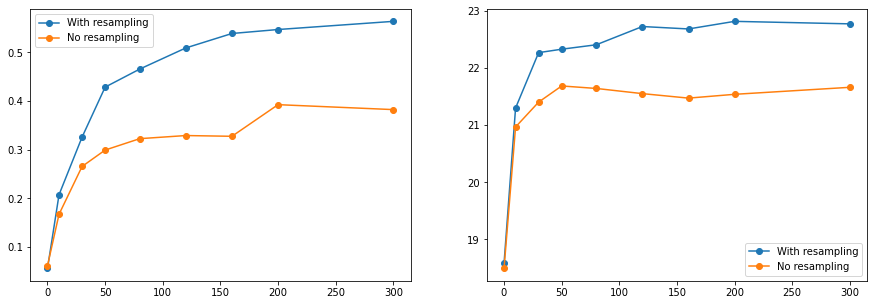

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax0.plot(my_range, ssim_list0, '-o', label='With resampling')
ax0.plot(my_range, ssim_list1, '-o', label='No resampling')
ax0.legend()

ax1.plot(my_range, psnr_list0, '-o', label='With resampling')
ax1.plot(my_range, psnr_list1, '-o', label='No resampling')
ax1.legend()

In [25]:
max(ssim_list0), max(ssim_list1)

(0.563350260257721, 0.392230361700058)

#### Fourier Bernoulli case

In [8]:
ssim_list0 = []
psnr_list0 = []

ssim_list1 = []
psnr_list1 = []

# my_range = [0, 10, 30, 50, 80, 120, 160, 200, 300]
my_range = [0, 30, 50, 120, 300]

for i in my_range:
    print(i)
    denoised_tomo = predict_full_tomogram(my_dataset, model, resample_patch_each_iter=True, N=i)
    X = torch.tensor(denoised_tomo).unsqueeze(0).unsqueeze(0)
    X = my_dataset.scale(X)

    Y = torch.tensor(my_dataset.gt_data).unsqueeze(0).unsqueeze(0)
    Y = my_dataset.scale(Y)

    _ssim = float(ssim(X, Y, data_range=1))

    _psnr = float(peak_signal_noise_ratio(X, Y, data_range=1))
    ssim_list0.append(_ssim)
    psnr_list0.append(_psnr)

for i in my_range:
    print(i)
    denoised_tomo = predict_full_tomogram(my_dataset, model, resample_patch_each_iter=False, N=i)
    X = torch.tensor(denoised_tomo).unsqueeze(0).unsqueeze(0)
    X = my_dataset.scale(X)

    Y = torch.tensor(my_dataset.gt_data).unsqueeze(0).unsqueeze(0)
    Y = my_dataset.scale(Y)

    _ssim = float(ssim(X, Y, data_range=1))

    _psnr = float(peak_signal_noise_ratio(X, Y, data_range=1))
    ssim_list1.append(_ssim)
    psnr_list1.append(_psnr)

0


100%|███████████████████████████████████████| 18/18 [00:01<00:00,  9.20it/s]


30


100%|███████████████████████████████████████| 18/18 [01:00<00:00,  3.38s/it]


50


100%|███████████████████████████████████████| 18/18 [01:41<00:00,  5.61s/it]


120


100%|███████████████████████████████████████| 18/18 [03:56<00:00, 13.16s/it]


300


100%|███████████████████████████████████████| 18/18 [10:07<00:00, 33.76s/it]


0


100%|███████████████████████████████████████| 18/18 [00:01<00:00,  9.43it/s]


30


100%|███████████████████████████████████████| 18/18 [00:52<00:00,  2.91s/it]


50


100%|███████████████████████████████████████| 18/18 [01:27<00:00,  4.86s/it]


120


100%|███████████████████████████████████████| 18/18 [03:28<00:00, 11.59s/it]


300


100%|███████████████████████████████████████| 18/18 [08:28<00:00, 28.27s/it]


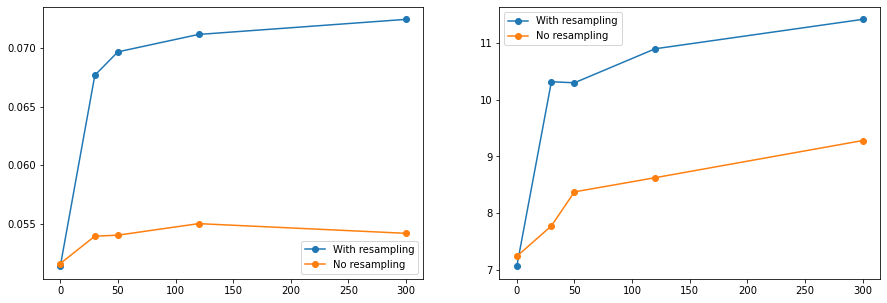

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax0.plot(my_range, ssim_list0, '-o', label='With resampling')
ax0.plot(my_range, ssim_list1, '-o', label='No resampling')
ax0.legend()

ax1.plot(my_range, psnr_list0, '-o', label='With resampling')
ax1.plot(my_range, psnr_list1, '-o', label='No resampling')
ax1.legend()

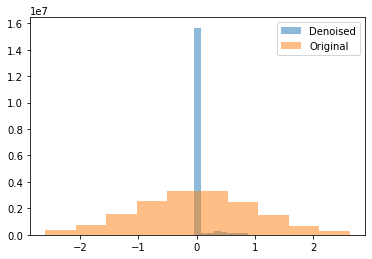

In [45]:
plt.hist(denoised_tomo.numpy().flatten(), alpha=0.5, label='Denoised')
plt.hist(my_dataset.data.numpy().flatten(), alpha=0.5, label='Original')
plt.legend()

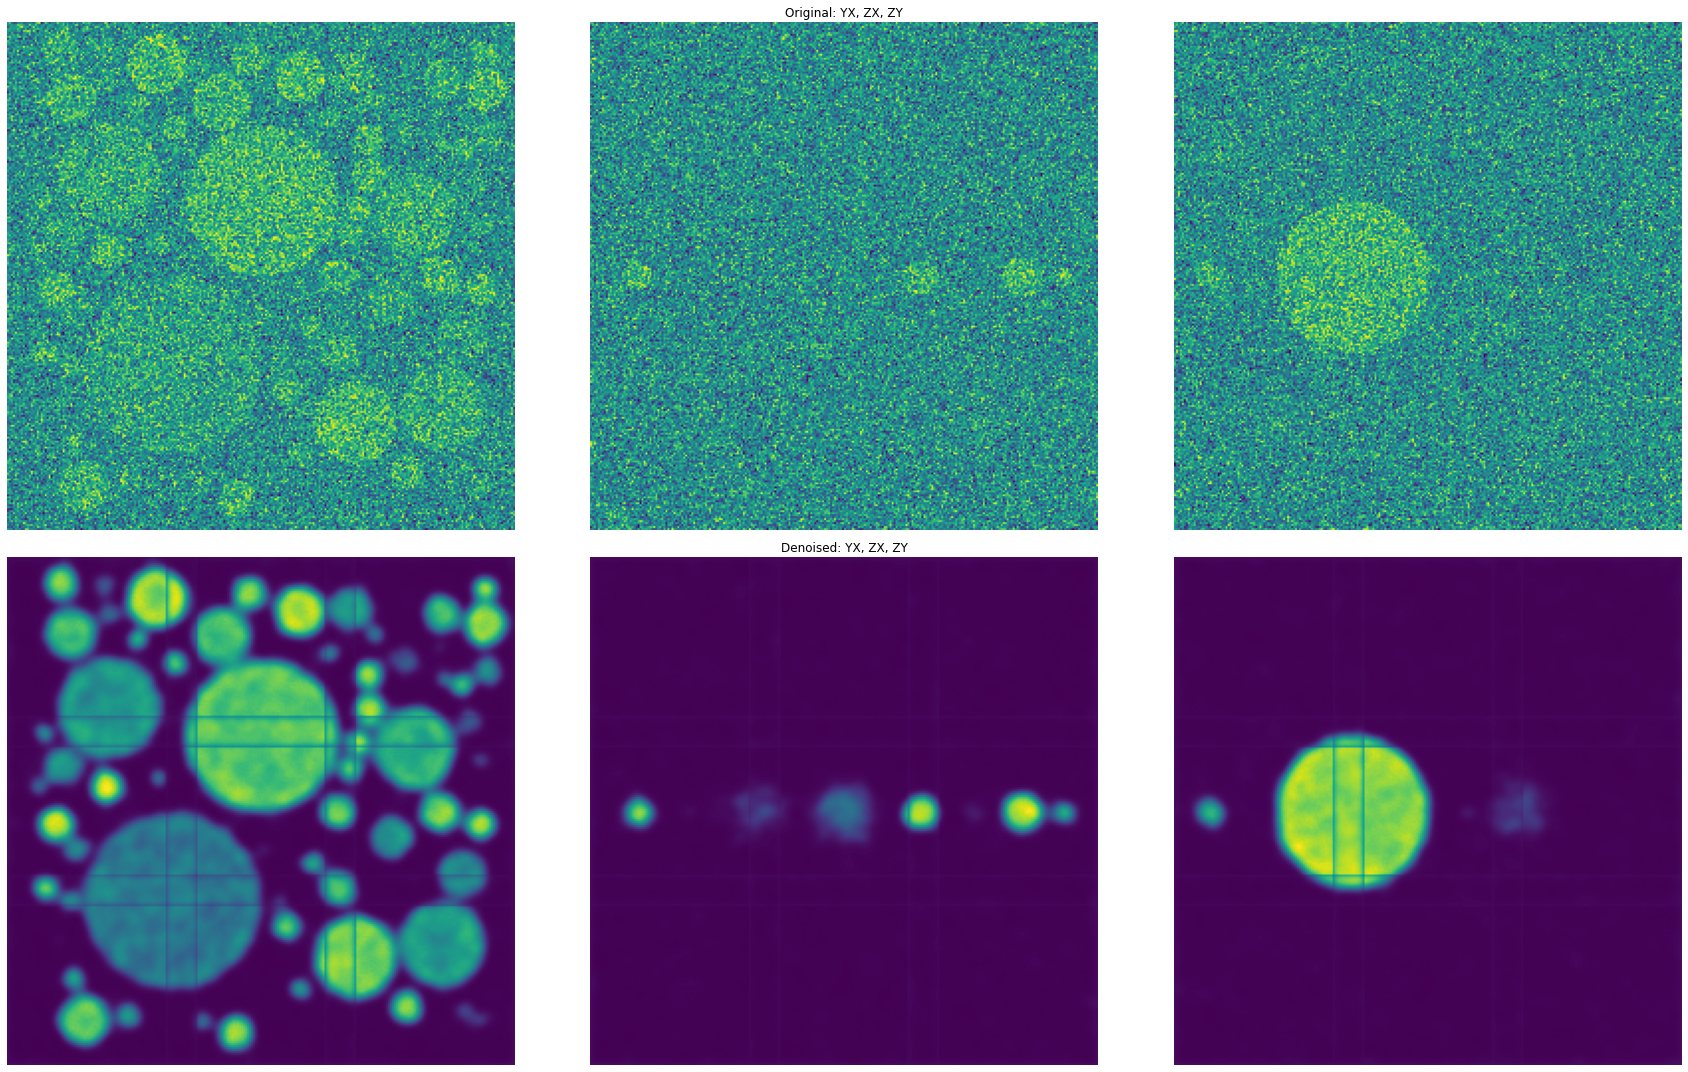

In [46]:
zidx, yidx, xidx = np.array(my_dataset.data.shape) // 2

fig, (ax0, ax1) = plt.subplots(2, 3, figsize=(25, 15))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1]).ravel()))

ax0[1].set_title("Original: YX, ZX, ZY")
ax0[0].imshow(my_dataset.data[zidx])
ax0[1].imshow(my_dataset.data[:, yidx, :])
ax0[2].imshow(my_dataset.data[:, :, xidx])

ax1[1].set_title("Denoised: YX, ZX, ZY")
ax1[0].imshow(denoised_tomo[zidx])
ax1[1].imshow(denoised_tomo[:, yidx, :])
ax1[2].imshow(denoised_tomo[:, :, xidx])

plt.tight_layout()

In [ ]:
# outfile = os.path.join(logdir, "original_vs_denoised.png")
# plt.savefig(outfile, dpi=200)

In [55]:
# filename = cet_path.split('/')[-1].replace('.mrc', '_s2sDenoised')
# v = version.replace('version_', 'v')
# filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/denoised/%s_%s.mrc' %(filename, v))

# write_array(denoised_tomo.numpy(), filename)

# Tomo04 Dummy Convolved

In [2]:
version = 'version_5'
logdir = 'data/S2SDenoising/model_logs/tomo04_dummy/fourierHFplusVolMask_comparison/'
logdir = os.path.join(PARENT_PATH, logdir+'%s/' %version)

with open(os.path.join(logdir, "experiment_args.json"), "r") as f:
    exp_args = json.load(f)

deconv_kwargs = exp_args["deconv_kwargs"]
predict_simRecon = exp_args["predict_simRecon"]
use_deconv_as_target = exp_args["use_deconv_as_target"]
bernoulliMask_prob = parse_null_arg(
    exp_args["bernoulliMask_prob"], float
)

model, hparams = load_model(logdir, DataParallel=True)

dataset = hparams['dataset']

cet_path = hparams['tomo_path']
gt_cet_path = hparams['gt_tomo_path']
p = float(hparams['p']) # dropout (zeroing) probability
subtomo_length = int(hparams['subtomo_length'])
n_features = int(hparams['n_features'])
volumetric_scale_factor = int(hparams['vol_scale_factor'])
Vmask_probability = float(hparams['Vmask_probability'])
Vmask_pct = float(hparams['Vmask_pct'])
alpha = hparams['loss_fn']['alpha']

n_bernoulli_samples = 1

In [3]:
if dataset == "singleCET_dataset":
    my_dataset = singleCET_dataset(
        cet_path,
        subtomo_length=subtomo_length,
        p=p,
        n_bernoulli_samples=n_bernoulli_samples,
        volumetric_scale_factor=volumetric_scale_factor,
        Vmask_probability=Vmask_probability,
        Vmask_pct=Vmask_pct,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        **deconv_kwargs
    )

elif dataset == "singleCET_FourierDataset":
    my_dataset = singleCET_FourierDataset(
        cet_path,
        subtomo_length=subtomo_length,
        p=p,
        n_bernoulli_samples=n_bernoulli_samples,
        total_samples=150,
        volumetric_scale_factor=volumetric_scale_factor,
        Vmask_probability=Vmask_probability,
        Vmask_pct=Vmask_pct,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        bernoulliMask_prob=bernoulliMask_prob,
        path_to_fourier_samples=os.path.join(logdir, 'singleCET_FourierDataset.samples'),
        **deconv_kwargs
    )

elif dataset == "singleCET_ProjectedDataset":
    my_dataset = singleCET_ProjectedDataset(
        cet_path,
        subtomo_length=subtomo_length,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        predict_simRecon=predict_simRecon,
        use_deconv_as_target=use_deconv_as_target,
        **deconv_kwargs
    )

Using deconvolved data for training.
Found existing samples. Loading samples...
Done!!


## With resampling and using existing samples

In [ ]:
all_preds_resampling = get_predictions(my_dataset, model, resample_patch_each_iter=True, N=300)

  0%|                                                | 0/75 [00:00<?, ?it/s]

In [ ]:
ssim_list_single = []
psnr_list_single = []

ssim_list_full = []
psnr_list_full = []

tomo_shape = my_dataset.tomo_shape
subtomo_length = my_dataset.subtomo_length

n_pred = 5

my_range = [1, 5, 10, 15, 30, 50, 80, 120, 170, 250, 300]

for n in tqdm(my_range):
    denoised_tomo_single = torch.zeros(tomo_shape)
    denoised_tomo = torch.zeros(tomo_shape)
    count_tensor = torch.zeros(tomo_shape)
    
    for idx in range(len(all_preds)):
        
        p0 = my_dataset.grid[idx]
        zyx_min = np.array(p0) - subtomo_length // 2
        zyx_max = np.array(p0) + subtomo_length // 2
        zmin, ymin, xmin = zyx_min
        zmax, ymax, xmax = zyx_max
        
        pred_single = all_preds_resampling[idx][n-1].mean(0).squeeze()
        denoised_tomo_single[zmin:zmax, ymin:ymax, xmin:xmax] += pred_single
        

        pred = all_preds_resampling[idx][0:n].mean(0).squeeze()
        denoised_tomo[zmin:zmax, ymin:ymax, xmin:xmax] += pred

        count_tensor[zmin:zmax, ymin:ymax, xmin:xmax] += 1

    denoised_tomo_single = denoised_tomo_single / count_tensor
    denoised_tomo_single = standardize(denoised_tomo_single)
    ssim_single, psnr_single = get_metrics(denoised_tomo_single, my_dataset.gt_data)
    ssim_list_single.append(ssim_single)
    psnr_list_single.append(psnr_single)
    
    denoised_tomo = denoised_tomo / count_tensor
    denoised_tomo = standardize(denoised_tomo)
    ssim_full, psnr_full = get_metrics(denoised_tomo, my_dataset.gt_data)
    ssim_list_full.append(ssim_full)
    psnr_list_full.append(psnr_full)
    
    if n in [1, 50, 120, 250]:
        print('Single tomo central slices for sample %i' %n)
        fig, ax = plot_centralSlices(denoised_tomo_single, True)

        print('Average tomo central slices with %i samples' %n)
        fig, ax = plot_centralSlices(denoised_tomo, True)

Text(0.5, 0.98, 'With resampling')

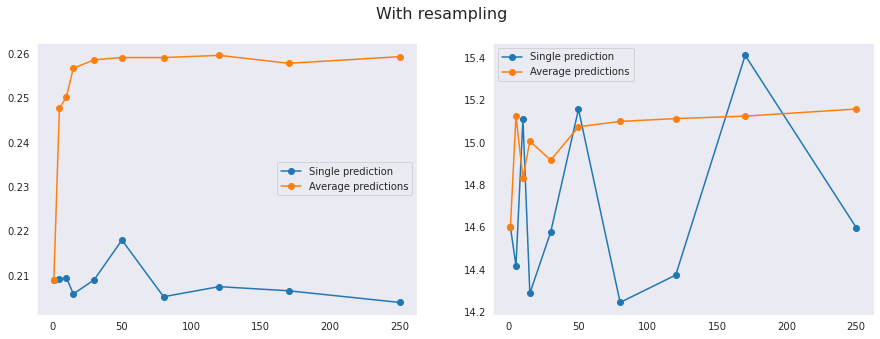

In [106]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax0.plot(my_range, ssim_list_single, '-o', label='Single prediction')
ax0.plot(my_range, ssim_list_full, '-o', label='Average predictions')
ax0.legend()

ax1.plot(my_range, psnr_list_single, '-o', label='Single prediction')
ax1.plot(my_range, psnr_list_full, '-o', label='Average predictions')
ax1.legend()

plt.suptitle('With resampling')

## No resampling and using existing samples

In [ ]:
all_preds_noResampling = get_predictions(my_dataset, model, resample_patch_each_iter=False, N=300)

In [ ]:
ssim_list_single = []
psnr_list_single = []

ssim_list_full = []
psnr_list_full = []

tomo_shape = my_dataset.tomo_shape
subtomo_length = my_dataset.subtomo_length

n_pred = 5

my_range = [1, 5, 10, 15, 30, 50, 80, 120, 170, 250, 300]

for n in tqdm(my_range):
    denoised_tomo_single = torch.zeros(tomo_shape)
    denoised_tomo = torch.zeros(tomo_shape)
    count_tensor = torch.zeros(tomo_shape)
    
    for idx in range(len(all_preds)):
        
        p0 = my_dataset.grid[idx]
        zyx_min = np.array(p0) - subtomo_length // 2
        zyx_max = np.array(p0) + subtomo_length // 2
        zmin, ymin, xmin = zyx_min
        zmax, ymax, xmax = zyx_max
        
        pred_single = all_preds_no_resampling[idx][n-1].mean(0).squeeze()
        denoised_tomo_single[zmin:zmax, ymin:ymax, xmin:xmax] += pred_single
        

        pred = all_preds_no_resampling[idx][0:n].mean(0).squeeze()
        denoised_tomo[zmin:zmax, ymin:ymax, xmin:xmax] += pred

        count_tensor[zmin:zmax, ymin:ymax, xmin:xmax] += 1

    denoised_tomo_single = denoised_tomo_single / count_tensor
    denoised_tomo_single = standardize(denoised_tomo_single)
    ssim_single, psnr_single = get_metrics(denoised_tomo_single, my_dataset.gt_data)
    ssim_list_single.append(ssim_single)
    psnr_list_single.append(psnr_single)
    
    denoised_tomo = denoised_tomo / count_tensor
    denoised_tomo = standardize(denoised_tomo)
    ssim_full, psnr_full = get_metrics(denoised_tomo, my_dataset.gt_data)
    ssim_list_full.append(ssim_full)
    psnr_list_full.append(psnr_full)
    
    if n in [1, 50, 120, 250]:
        print('Single tomo central slices for sample %i' %n)
        fig, ax = plot_centralSlices(denoised_tomo_single, True)

        print('Average tomo central slices with %i samples' %n)
        fig, ax = plot_centralSlices(denoised_tomo, True)

Text(0.5, 0.98, 'With resampling')

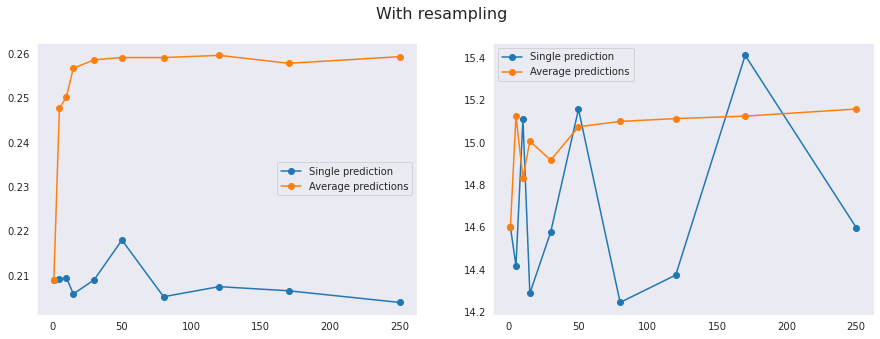

In [106]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax0.plot(my_range, ssim_list_single, '-o', label='Single prediction')
ax0.plot(my_range, ssim_list_full, '-o', label='Average predictions')
ax0.legend()

ax1.plot(my_range, psnr_list_single, '-o', label='Single prediction')
ax1.plot(my_range, psnr_list_full, '-o', label='Average predictions')
ax1.legend()

plt.suptitle('No resampling')